<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [230]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
import patsy

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [231]:
# Load the data
house = pd.read_csv('./housing.csv')

# END GOAL 
Develop an algorithm to reliably estimate the value of residential houses based on FIXED CHARACTERISTICS.

Step 1: Identify and isolate the target and predictor variables.

Predictor variables will be features of the house that are fixed.
Target variable will be the sale price.

Step 2: Split the data into pre-2010 data and 2010 data.

Step 3: Train and fit a suitable model.

In [232]:
house.shape
# House data has 1460 rows and 81 columns

(1460, 81)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


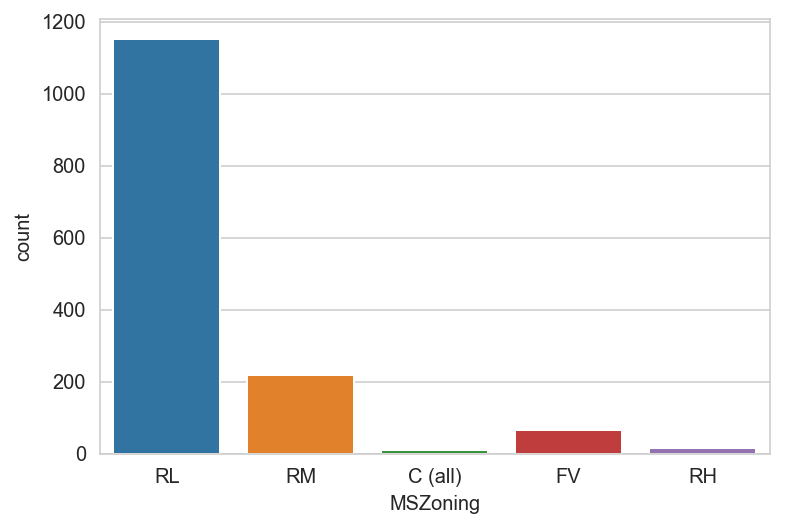

In [233]:
# RL, RM, C (all), FV, RH are the types
# C (all) represents the commercial type of properties
sns.countplot(house['MSZoning'])
print(house['MSZoning'].value_counts())

# Getting rid of the non-residential houses
house = house[house['MSZoning'] != 'C (all)']

In [234]:
# Creating a function to sieve out all the features that are predominantly one class
# Features that are predominantly 1 class aren't of much value because they show little variation in the infomation they give
majority_list = []
def proportion_majority(column):
    max_count = house[column].value_counts().max()
    majority_list.append(float(max_count)/len(house))

In [235]:
# I'll arbitrarily set the threshold to be at around 95% 
# Therefore, stuff to be dropped are KitchenAbvGr onwards
for column in house.columns:
    proportion_majority(column)
    
column_df = pd.DataFrame(house.columns)
majority_df = pd.DataFrame(majority_list)
majority = pd.concat([column_df, majority_df], axis=1)
majority.columns = ['Feature', 'Majority Proportion']
majority.sort_values(by='Majority Proportion', ascending=False)

,Feature,Majority Proportion
9,Utilities,0.999310
5,Street,0.997241
71,PoolArea,0.995172
14,Condition2,0.990345
69,3SsnPorch,0.983448
45,LowQualFinSF,0.982759
22,RoofMatl,0.982069
39,Heating,0.978621
75,MiscVal,0.965517
52,KitchenAbvGr,0.953793


In [236]:
# Dropping the following features
drop = ['Utilities', 'Street', 'PoolArea', 'Condition2', '3SsnPorch', 'LowQualFinSF', 
        'RoofMatl', 'Heating', 'MiscVal', 'KitchenAbvGr']

def dropper(column):
    house.drop(labels=column, inplace=True, axis=1)

for column in drop:
    dropper(column)


In [237]:
# Checking correlation between features to determine which to select
corr = house.corr().abs()
corr_unstacked = corr.unstack()
corr_df = pd.DataFrame(corr_unstacked.sort_values(ascending=False))
corr_df.columns = ['Correlation Value']
corr_df[corr_df['Correlation Value'] != 1].sort_values(by='Correlation Value', ascending=False).head(50)

# Garage Cars vs Garage Area (I think people tend to look at how many cars house can hold rather than area) - Drop GarageArea
# Nth much else that I can pick on

,,Correlation Value
GarageCars,GarageArea,0.883009
GarageArea,GarageCars,0.883009
GarageYrBlt,YearBuilt,0.829667
YearBuilt,GarageYrBlt,0.829667
TotRmsAbvGrd,GrLivArea,0.825183
GrLivArea,TotRmsAbvGrd,0.825183
1stFlrSF,TotalBsmtSF,0.819138
TotalBsmtSF,1stFlrSF,0.819138
OverallQual,SalePrice,0.789031
SalePrice,OverallQual,0.789031


In [238]:
# Creating a feature for age of property when sold
# Age of property when sold = (YrSold + MoSold/12) - YearBuilt
house['AgeWhenSold'] = house['YrSold'] + (house['MoSold'] / 12) - house['YearBuilt']
dropper('GarageArea')

In [239]:
# Basement is separated into finished and unfinished type
# TotalBsmtSF measures the total basement area (unfinished + finished)
# BsmtFinSF1 & BsmtFinSF2 measures the total finished basement area
# Therefore, would be best to combine them
house['BsmtTotFinSF'] = house['BsmtFinSF1'] + house['BsmtFinSF2']

drop = ['BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF',]
for column in drop:
    dropper(column)

In [240]:
house.isnull().sum().sort_values(ascending=False)
# There are some columns with a large number of null values
# Lets check some of them out

PoolQC           1443
MiscFeature      1398
Alley            1361
Fence            1172
FireplaceQu       681
LotFrontage       259
GarageType         79
GarageCond         79
GarageYrBlt        79
GarageFinish       79
GarageQual         79
BsmtFinType2       38
BsmtExposure       38
BsmtCond           37
BsmtQual           37
BsmtFinType1       37
MasVnrArea          8
MasVnrType          8
Electrical          1
Condition1          0
MSSubClass          0
MSZoning            0
LotArea             0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
Neighborhood        0
YearRemodAdd        0
                 ... 
RoofStyle           0
BsmtTotFinSF        0
BsmtUnfSF           0
HeatingQC           0
SalePrice           0
SaleCondition       0
SaleType            0
YrSold              0
MoSold              0
ScreenPorch         0
EnclosedPorch       0
OpenPorchSF         0
WoodDeckSF          0
PavedDrive          0
GarageCars

In [241]:
# PoolQC supposed values are Ex, Gd, TA, Fa and NA
# NA for no swimming pool
# I think the nan are meant to reflect that
house['PoolQC'].unique()

# Filling up the PoolQC nulls with None
house['PoolQC'].fillna('None', inplace=True)

In [242]:
# MiscFeature is used to specify if the house has any miscellaneous features such as a tennis court or shed etc...
# Values are Elev, Gar2, Othr, Shed, TenC and NA 
# NA stands for None
# I'll assume the nan in this feature means that the house has no miscellaneous features
house['MiscFeature'].unique()

# Filling up the MiscFeature nulls with None
house['MiscFeature'].fillna('None', inplace=True)

In [243]:
# Same as the above, I'll fill up nan with None
house['Alley'].unique()

house['Alley'].fillna('None', inplace=True)

In [244]:
# Same as the above, I'll fill up nan with None
house['Fence'].unique()

house['Fence'].fillna('None', inplace=True)

In [245]:
# Same as the above, I'll fill up nan with None
house['FireplaceQu'].unique()

house['FireplaceQu'].fillna('None', inplace=True)

In [246]:
# LotFrontage specifies the linear feet of street connected to property
# I think NaN here is because some houses might be apartment, in that case it doesn't make sense that there
# is street space connected to the property. So for NaN values here I'll replace it with 0
house['LotFrontage'].fillna(0, inplace=True)

In [247]:
# Same as the above, I'll fill up nan with None
house['GarageType'].fillna('None', inplace=True)
house['GarageCond'].fillna('None', inplace=True)
house['GarageFinish'].fillna('None', inplace=True)
house['GarageQual'].fillna('None', inplace=True)
house.drop(labels='GarageYrBlt', axis=1, inplace=True)

In [248]:
# Same as the above, I'll fill up nan with None
house['BsmtFinType2'].fillna('None', inplace=True)
house['BsmtExposure'].fillna('None', inplace=True)
house['BsmtCond'].fillna('None', inplace=True)
house['BsmtQual'].fillna('None', inplace=True)
house['BsmtFinType1'].fillna('None', inplace=True)

In [249]:
house['MasVnrArea'].fillna(0, inplace=True)
house['MasVnrType'].fillna('None', inplace=True)

In [250]:
house['Electrical'].unique()
house['Electrical'].fillna('None', inplace=True)

In [251]:
house.isnull().sum().sort_values(ascending=False)

BsmtTotFinSF     0
ExterCond        0
RoofStyle        0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
Foundation       0
AgeWhenSold      0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
BsmtUnfSF        0
YearRemodAdd     0
YearBuilt        0
OverallCond      0
OverallQual      0
HouseStyle       0
BldgType         0
Condition1       0
Neighborhood     0
LandSlope        0
LotConfig        0
LandContour      0
LotShape         0
Alley            0
LotArea          0
                ..
SaleCondition    0
SaleType         0
YrSold           0
MoSold           0
MiscFeature      0
Fence            0
PoolQC           0
ScreenPorch      0
EnclosedPorch    0
OpenPorchSF      0
WoodDeckSF       0
PavedDrive       0
GarageCond       0
GarageCars       0
1stFlrSF         0
GarageFinish     0
GarageType       0
FireplaceQu      0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
KitchenQual 

In [252]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtUnfSF', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'PoolQC', 'Fence', 'MiscFeature',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice',
       'Age

In [253]:
# Combining all the half and full bathroom counts together
# It makes more sense that people look at number of bathrooms as a whole when determining price
house['TotHalfBath'] = house['BsmtHalfBath'] + house['HalfBath']
house['TotFullBath'] = house['BsmtFullBath'] + house['FullBath']



# Going to include 1stFlrSF and 2ndFlrSF in drop list as they are very likely included in MasVnrArea
drop = ['BsmtHalfBath', 'HalfBath', 'BsmtFullBath', 'FullBath', '1stFlrSF', '2ndFlrSF']
for feature in drop:
    dropper(feature)

In [254]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtUnfSF', 'HeatingQC', 'CentralAir', 'Electrical', 'GrLivArea',
       'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'PoolQC', 'Fence', 'MiscFeature',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice',
       'AgeWhenSold', 'BsmtTotFinSF', 'TotHalfBath', 'TotFullBath'],
      dtype='object')

List of fixed features:

Categorical
1. MSSubClass 
2. MSZoning 
3. Neighborhood 
4. Bldgtype 
5. HouseStyle 
6. MasVnrType 
7. Foundation 
8. BsmtQual 
9. LotShape
10. LotContour
11. LotConfig
12. LandSlope

Continuous
1. MasVnrArea 
2. LowQualFinSF 
3. GrLivArea
4. TotFullBath
5. TotHalfBath
6. Bedroom
7. Kitchen
8. TotRmsAbvGrd
9. Fireplaces
10. GarageCars
11. GarageArea
12. PoolArea
13. LotFrontage
14. LotArea


In [255]:
features = ['MSSubClass', 'MSZoning', 'Neighborhood', 'BldgType',
            'HouseStyle', 'MasVnrType', 'Foundation', 'BsmtQual',
            'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
            'MasVnrArea', 'GrLivArea', 'TotFullBath',
            'TotHalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
            'Fireplaces', 'GarageCars',
            'LotFrontage', 'LotArea', 'SalePrice', 'AgeWhenSold', 'YrSold']

# features_cont = ['MasVnrArea', 'LowQualFinSF', 'GrLivArea', 'TotFullBath',
#                 'TotHalfBath', 'Bedroom', 'Kitchen', 'TotRmsAbvGrd',
#                 'Fireplaces', 'GarageCars', 'GarageArea', 'PoolArea',
#                 'LotFrontage', 'LotArea']

# features_cat = ['MSSubClass', 'MSZoning', 'Neighborhood', 'Bldgtype',
#                'HouseStyle', 'MasVnrType', 'Foundation', 'BsmtQual',
#                'LotShape', 'LotContour', 'LotConfig', 'LandSlope']

In [256]:
house = house[features]

In [272]:
static_features = '''
            SalePrice ~ MSSubClass + MSZoning + Neighborhood + BldgType +
            HouseStyle + MasVnrType + Foundation + BsmtQual +
            LotShape + LandContour + LotConfig + LandSlope +
            MasVnrArea + GrLivArea + TotFullBath +
            TotHalfBath + BedroomAbvGr + KitchenQual + TotRmsAbvGrd +
            Fireplaces + GarageCars +
            LotFrontage + LotArea + AgeWhenSold -1
            '''

In [273]:
test_2010 = house['YrSold'] == 2010

In [274]:
y, X = patsy.dmatrices(static_features, data=house, return_type='dataframe')
y = y.values.ravel()
print(y.shape, X.shape)

(1450,) (1450, 78)


In [275]:
# Standardizing X before splitting into training and testing sets
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [276]:
# Splitting into training and test sets (test is 2010 data)
X_train, X_test = Xs[~test_2010], Xs[test_2010]
y_train, y_test = y[~test_2010], y[test_2010]

In [277]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [278]:
lasso_cv = LassoCV(n_alphas=300, cv=10, verbose=1, n_jobs=-1)
lasso_cv.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=-1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=1)

In [279]:
lasso_feat = pd.DataFrame(dict(feature=X.columns, 
                               coefficients=lasso_cv.coef_,
                               absolute_coefficient = np.abs(lasso_cv.coef_)))

lasso_feat.sort_values(by='absolute_coefficient', inplace=True, ascending=False)


In [280]:
lasso_feat

,feature,coefficients,absolute_coefficient
68,GrLivArea,28872.223811,28872.223811
65,KitchenQual[T.TA],-19917.092650,19917.092650
50,BsmtQual[T.TA],-17653.235091,17653.235091
48,BsmtQual[T.Gd],-16190.429949,16190.429949
64,KitchenQual[T.Gd],-13866.960702,13866.960702
18,Neighborhood[T.NoRidge],10486.159605,10486.159605
19,Neighborhood[T.NridgHt],10293.911182,10293.911182
69,TotFullBath,7905.333049,7905.333049
74,GarageCars,7825.992472,7825.992472
49,BsmtQual[T.None],-7742.957615,7742.957615


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [9]:
# Identify renovatable features:
# Some examples of things that ARE renovate-able:
# Roof and exterior features, "Quality" metrics, such as kitchen quality
# "Condition" metrics, such as condition of garage, Heating and electrical components

# Renovatable features:
# LotFrontage, LotArea, Street, Alley, LotShape, LandContour, OverallQual,
# OverallCond, YearBuilt, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, 
# ExterQual, ExterCond, BmstCond, BmstExposure, Heating, HeatingQC, Electrical
# KitchenQual, Functional, FireplaceQu, GarageFinish, GarageQual, GarageCond,
# PoolQC, YrSold


# y_test is still ys_test
# y_train is still ys_train

predictors1 = house_resi[['LotArea', 'Street', 
                          'LotShape', 'LandContour', 'OverallQual', 'OverallCond',
                          'YearBuilt', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
                          'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtCond',
                          'BsmtExposure', 'Heating', 'HeatingQC', 'Electrical',
                          'KitchenQual', 'Functional', 
                          
                          'YrSold']]



NameError: name 'house_resi' is not defined

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [11]:
# A: